#Introduction

This lab is devoted to **Neural Machine Translation.**

Today we will train and evaluate RNN Encoder-Decoder with Attention.

# RNN Encoder-Decoder with Attention

## Prerequisites

In [ ]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import math, copy, time
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0')
print("CUDA is available:", USE_CUDA)
print("Which device:", DEVICE)

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA is available: True
Which device: cuda:0


We will use [spacy](https://github.com/explosion/spaCy) for tokenization

In [ ]:
pip install torchtext==0.4.0


     |████████████████████████████████| 61kB 6.4MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [ ]:
!pip3 install git+git://github.com/pytorch/text spacy 
!python -m spacy download en
!python -m spacy download de

  Cloning git://github.com/pytorch/text to /tmp/pip-req-build-ll7fykd6
  Running command git clone -q git://github.com/pytorch/text /tmp/pip-req-build-ll7fykd6
  Running command git submodule update --init --recursive -q
  Created wheel for torchtext: filename=torchtext-0.9.0a0+97e6d1d-cp36-cp36m-linux_x86_64.whl size=6980403 sha256=e3b1c4767ece4277e46d4837df708c18254324b3f0d07a6818f4bf8be364fab9
  Stored in directory: /tmp/pip-ephem-wheel-cache-_jahxt_e/wheels/39/42/ff/82f5ccbb0f30b25e14610376f5d0c67913fc05017dab59f8eb
Successfully built torchtext
  Found existing installation: torchtext 0.4.0
    Uninstalling torchtext-0.4.0:
      Successfully uninstalled torchtext-0.4.0
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████

## Data
Machine Translation dataset is a parallel (bilingual) corpus. Which means it is a dataset created out of source language sentences with their corresponding target language translations. We need to take care of two things:
* source language vocabulary and target language vocabulary
* source sentences and their translations (target sentences) may have different lenghts => variable-length sequences

###Exercise 1: Preprocessing

We will download, lowercase and tokenize the IWSLT data for the English-German language pair.

As we want our model to perform fast, we only include words that occur min 5 times as well as limit the length of sentences to max 25 words.

In [ ]:
import spacy
from torchtext import data, datasets

SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"
MIN_FREQ = 5  # min number of times a word occurs
MAX_LEN = 25  # max number of words per sentence

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = data.Field(tokenize=tokenize_de, batch_first=True, lower=True, include_lengths=True,
                  unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
TRG = data.Field(tokenize=tokenize_en, batch_first=True, lower=True, include_lengths=True,
                  unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


####Exercise 1.1: Split data to training, validation and test datasets

Use `datasets.IWSLT.splits` [method](https://torchtext.readthedocs.io/en/latest/data.html#torchtext.data.Dataset.splits). 

Execution of this cell will take a while.

In [ ]:
train_data, valid_data, test_data = datasets.IWSLT.splits(
    exts=('.de', '.en'), fields=(SRC, TRG), 
    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)#TODO

downloading de-en.tgz


de-en.tgz: 100%|██████████| 24.2M/24.2M [00:03<00:00, 6.24MB/s]


.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.en.xml
.data/iwslt/de-en/train.tags.de-en.de
.data/iwslt/de-en/train.tags.de-en.en


/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


####Exercise 1.2: Build vocabulary for SRC and TRG

In [ ]:
SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)#TODO
TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)#TODO

PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

Now, let's check how our data look

In [ ]:
def show_data_stats(train_data, valid_data, test_data, src_field, trg_field):
    print("src vocabulary size:", len(src_field.vocab))
    print("trg vocabulary size:", len(trg_field.vocab), "\n")

    print("Number of sentence pairs:")
    print('train:', len(train_data))
    print('valid:', len(valid_data))
    print('test:', len(test_data), "\n")

    print("Let's take a look at an exemplary pair of sentences:")
    print("src:", " ".join(vars(train_data[100])['src']))
    print("trg:", " ".join(vars(train_data[100])['trg']), "\n")   
    
show_data_stats(train_data, valid_data, test_data, SRC, TRG)

src vocabulary size: 15765
trg vocabulary size: 13002 

Number of sentence pairs:
train: 143115
valid: 690
test: 963 

Let's take a look at an exemplary pair of sentences:
src: man sieht heißes wasser hier , hier , hier und hier austreten .
trg: you see the hot water over here , here and here , coming out . 



## Model

Below we implement a standard Encoder-Decoder architecture. The encoder returns its final states (`encoder_final`), which is used to initialize the decoder RNN.

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)

####Exercise 2.1: Define softmax generation step

In [ ]:
class Generator(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1) #TODO

### Encoder

We will implement a bi-directional GRU encoder.
We will leverage mini-batches to speed up computations. Remember that sentences in mini-batches may be of different lenghts. PyTorch is able to deal with this by means of `pack_padded_sequence` and `pad_packed_sequence` functions, which support masking and padding.

####Exercise 2.2: Return a final vector of the source sentence

Encoder reads a source sentence and generates hidden states. Once finished, the encoder returns a final vector, which represents the complete sentence. **It is constructed as a concatenation of the last and the first hidden states (because it is bi-directional!)**. This final vector will be used to initialize the decoder.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        left_right_final = final[0:final.size(0):2]
        right_left_final = final[1:final.size(0):2]
        final = torch.cat([left_right_final, right_left_final], dim=2)#TODO

        return output, final

### Decoder

Initial hidden state of the decoder is initialized with a projection of the encoder final state.
In function `forward` there's a for-loop that computes the decoder hidden states one time step at a time. In training mode we use `teacher forcing` as we know the targets. In prediction time the model uses embedding of the previously predicted word and the last hidden state.

####Exercise 2.3: Initialize decoder conditioned on the encoder final vector.

In [ ]:
class Decoder(nn.Module):    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5, bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
                 
        # Initialization from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None
        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size, hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        query = hidden[-1].unsqueeze(1)
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)
        
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        if max_len is None:
            max_len = trg_mask.size(-1)
        if hidden is None:
            hidden = self.init_hidden(encoder_final)

        proj_key = self.attention.key_layer(encoder_hidden)
        decoder_states = []
        pre_output_vectors = []
        
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors

    def init_hidden(self, encoder_final):
        if encoder_final is None:
            return None
        return torch.tanh(self.bridge(encoder_final))#TODO            


### Attention

####Exercise 2.4: Compute context vector, which is the weighted sum of the encoder hidden states (values)

In [ ]:
class AdditiveAttention(nn.Module):    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(AdditiveAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)

        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"
        query = self.query_layer(query)

        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas               
        context = torch.bmm(alphas, value)#TODO
        
        return context, alphas

### Initialization

In [ ]:
def init_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    attention = AdditiveAttention(hidden_size)
    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model

## Training

### Batching

In [ ]:
class Batch:
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()
                

In [ ]:
train_iter = data.BucketIterator(train_data, batch_size=64, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)


def rebatch(pad_idx, batch):
    return Batch(batch.src, batch.trg, pad_idx)

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


### Training Loop

In [ ]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" % (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))

### Loss

In [ ]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

### Greedy decoding

In [ ]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

### Training

In [ ]:
def train(model, num_epochs=3, lr=0.0003, print_every=100):    
    if USE_CUDA:
        model.cuda()

    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)    
    dev_perplexities = []

    for epoch in range(num_epochs):      
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities        

In [ ]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
      
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break

In [ ]:
model = init_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
dev_perplexities = train(model, print_every=100)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0


/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch Step: 100 Loss: 42.903297 Tokens per Sec: 22079.310911
Epoch Step: 200 Loss: 37.614697 Tokens per Sec: 24819.098881
Epoch Step: 300 Loss: 11.525517 Tokens per Sec: 24368.179367
Epoch Step: 400 Loss: 63.212666 Tokens per Sec: 24858.623447
Epoch Step: 500 Loss: 42.506031 Tokens per Sec: 25640.007368
Epoch Step: 600 Loss: 64.898048 Tokens per Sec: 24686.008223
Epoch Step: 700 Loss: 54.803696 Tokens per Sec: 23705.350155
Epoch Step: 800 Loss: 77.154495 Tokens per Sec: 25198.702859
Epoch Step: 900 Loss: 96.389854 Tokens per Sec: 25145.949197
Epoch Step: 1000 Loss: 53.864231 Tokens per Sec: 24869.382952
Epoch Step: 1100 Loss: 16.770924 Tokens per Sec: 24976.808297
Epoch Step: 1200 Loss: 28.194580 Tokens per Sec: 24485.331220
Epoch Step: 1300 Loss: 65.433876 Tokens per Sec: 24977.469036
Epoch Step: 1400 Loss: 94.230202 Tokens per Sec: 25289.855442
Epoch Step: 1500 Loss: 28.247158 Tokens per Sec: 24822.045414
Epoch Step: 1600 Loss: 20.518684 Tokens per Sec: 24469.769542
Epoch Step: 1700 

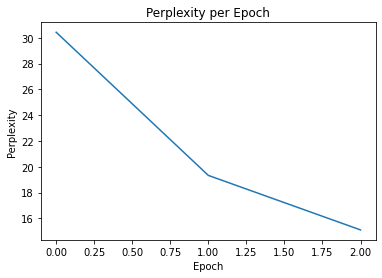

In [ ]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    
plot_perplexity(dev_perplexities)

### Evaluation

In [ ]:
!pip install sacrebleu
import sacrebleu

hypotheses = ["this is a test"]
references = ["this is a evaluation"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

22.360679774997894


In [ ]:
len(valid_data)
references = [" ".join(example.trg) for example in valid_data]
print(len(references))

690


In [ ]:
hypotheses = []
alphas = []  # attention scores
for batch in valid_iter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = greedy_decode(
    model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]
hypotheses = [" ".join(x) for x in hypotheses]

assert(len(hypotheses) == len(references))

bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


19.369174654083444


### Visualization of Attention

In [ ]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')
    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()
    plt.colorbar(heatmap)
    plt.show()

src ['"', 'jetzt', 'kannst', 'du', 'auf', 'eine', 'richtige', 'schule', 'gehen', ',', '"', 'sagte', 'er', '.', '</s>']
ref ['"', 'you', 'can', 'go', 'to', 'a', 'real', 'school', 'now', ',', '"', 'he', 'said', '.', '</s>']
pred ['"', 'now', 'you', 'can', 'go', 'to', 'a', 'right', 'school', ',', '"', 'he', 'said', '.', '</s>']


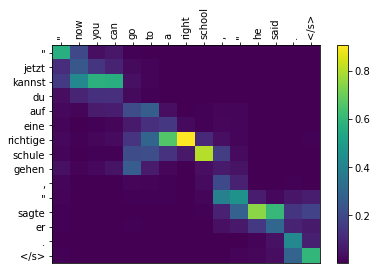

In [ ]:
idx = 5
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)

## Wrap-up

Now you know all the nitty-gritty of the Encoder-Decoder architecture implemented using RNNs and attention mechanism. 

Here are some suggestions how to improve the model:
- train for more epochs (now `num_epochs` is set to 3 but you can try with for example `num_epochs=10` and see if the perplexity and bleu scores improve)
- use BPEs
- use beam search instead of greedy decoding
- add more layers to encoder/decoder

## References
* BPE - [paper](https://arxiv.org/abs/1508.07909) and [code](https://github.com/rsennrich/subword-nmt)
* BLEU - [paper](https://www.aclweb.org/anthology/P02-1040/) and [code](https://github.com/moses-smt/mosesdecoder/blob/master/scripts/generic/multi-bleu.perl)
* Attention - [additive](https://arxiv.org/abs/1409.0473) and [multiplicative](https://arxiv.org/abs/1508.04025)
